# Preprocess data

In [1]:
import csv
import cv2
import gzip
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle
import sklearn
import random

from sklearn.model_selection import train_test_split

In [2]:
def load_zipped_pickle(file_path):
    with gzip.open(file_path, 'rb') as f:
        loaded_object = pickle.load(f)
        return loaded_object

In [3]:
def data_generator(samples, shape, batch_size=32):
    num_samples = len(samples)
    rows, cols, ch = shape
    
    while True:
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset + batch_size]

            X = np.zeros(shape=(batch_size, rows, cols, ch), dtype=np.float32)
            y = np.zeros(shape=(batch_size), dtype=np.float32)
            for i, sample in enumerate(batch_samples):
                # read driving log data
                img_path = '../' +  sample[0]
                angle = float(sample[1])
                
                # get image
                img = load_zipped_pickle(img_path)
                
                # load images and steering angles
                X[i] = img
                y[i] = angle

            yield sklearn.utils.shuffle(X, y)

In [4]:
samples = []
with open('../data/interim/center/driving_log.csv') as csvfile:
    reader = csv.reader(csvfile)
    for line in reader:
        samples.append(line)

In [5]:
samples = random.sample(samples, 100)
samples[0]

['data/interim/center/img/center_2016_12_01_13_41_19_039.jpg', '-0.05975719']

x shape = (32, 80, 320, 3)
y shape = (32,)
[-0.05975719 -0.05975719  0.00884002  0.30097321  0.          0.
  0.07072017  0.          0.00442016  0.          0.04862026 -0.2784608
  0.01768004  0.          0.04262284  0.17238051 -0.06925154  0.          0.
  0.01768004  0.2121605  -0.05975719  0.03978024 -0.03094022  0.17658231
  0.16701379 -0.5569213   0.0904655  -0.26962081  0.3583844  -0.01326017
 -0.00442016]


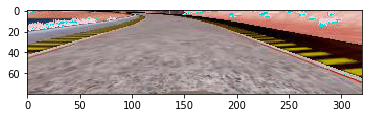

In [6]:
test_generator = data_generator(samples[0:100], shape=(80, 320, 3), batch_size=32)

for i in range(1):
    X_batch, y_batch = next(test_generator)
    print('x shape = {}\ny shape = {}'.format(X_batch.shape, y_batch.shape))
    print(y_batch)
    plt.imshow(X_batch[0])
    plt.show()

# Keras modelling

In [7]:
from keras.models import Sequential
from keras.layers import Lambda, MaxPooling2D, Flatten, Dense, Dropout
from keras.layers.convolutional import Convolution2D
from keras.optimizers import Adam

Using TensorFlow backend.


In [15]:
# hyper parameters
epochs = 3
batch_size = 32

In [9]:
# set known image attributes
shape = (80, 320, 3)

# set train and validate sets
train_samples, validation_samples = train_test_split(samples, test_size=0.2)

# set generator functions
train_generator = data_generator(train_samples, 
                                 shape=shape, 
                                 batch_size=batch_size)
validation_generator = data_generator(validation_samples, 
                                      shape=shape,
                                      batch_size=batch_size)

In [10]:
# https://arxiv.org/pdf/1604.07316.pdf
# model architecture
model = Sequential()

# normalisation
model.add(Lambda(lambda x: x / 255.0 - 0.5, input_shape=shape))

# Convolution2D(filters, kernel, stride)
model.add(Convolution2D(24, 5, 2, activation='relu'))
model.add(Convolution2D(36, 5, 2, activation='relu'))
model.add(Convolution2D(48, 5, 2, activation='relu'))
model.add(Convolution2D(64, 3, 3, activation='relu'))
model.add(Convolution2D(64, 3, 3, activation='relu'))

# flatten
model.add(Flatten())

# fully connected 1
model.add(Dense(100, activation='relu'))
model.add(Dropout(.5))

# fully connected 2
model.add(Dense(50, activation='relu'))
model.add(Dropout(.25))

# fully connected 3
model.add(Dense(10, activation='relu'))
model.add(Dropout(.25))

# output
model.add(Dense(1))

In [16]:
model.compile(optimizer=Adam(lr=1e-04), loss='mean_squared_error')

history_object = model.fit_generator(train_generator, 
                                     samples_per_epoch=len(train_samples), 
                                     validation_data=validation_generator, 
                                     nb_val_samples=len(validation_samples), 
                                     nb_epoch=epochs,
                                     verbose=2)

Epoch 1/3


/root/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/keras/engine/training.py:1569: UserWarning: Epoch comprised more than `samples_per_epoch` samples, which might affect learning results. Set `samples_per_epoch` correctly to avoid this warning.
  warnings.warn('Epoch comprised more than '


148s - loss: 1.0256 - val_loss: 0.1198
Epoch 2/3
32s - loss: 1.7247 - val_loss: 0.0325
Epoch 3/3
31s - loss: 0.6597 - val_loss: 0.0946


In [17]:
# print the keys contained in the history object
print(history_object.history.keys())

dict_keys(['loss', 'val_loss'])


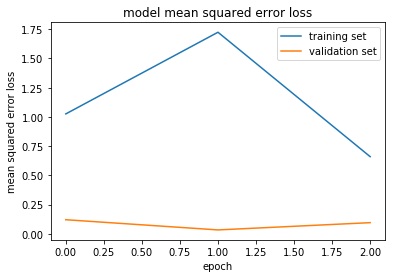

In [18]:
# plot the training and validation loss for each epoch
plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()